### Data Analysis - NSF Research Awards Abstracts
- Author: Jesus Ramseths
- Date: 17/07/2024

Overview:
- The NSF (National Science Foundation) Research Awards Abstracts are detailed descriptions of research projects funded by the NSF. These abstracts provide a summary of the research goals, methods, and expected outcomes of each awarded project. The abstracts are part of the NSF Award Search database, which allows users to explore funded projects by various criteria such as keywords, institutions, and program areas.

In [2]:
import pandas as pd
import spacy
import gensim
import numpy as np
from gensim import corpora
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
import nltk
import re
from matplotlib import pyplot as plt
from nltk.corpus import stopwords
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
pd.set_option('display.float_format', '{:.2f}'.format)

### 1. Data load

In [59]:
# Get data
original_data = pd.read_csv('./../data/trusted/nsf_research_awards_abstracts.csv')
print(f'Total rows: {original_data.shape}')

Total rows: (13300, 5)


### 2. Descriptive statistics

In [60]:
# Get a brief summary
original_data.describe(include=['object'])

,date,country,researcher,text
count,13300,13300,13299,13159
unique,224,9,11921,11712
top,09/01/2020,United States,Jerene Shaheed,The National Science Foundation (NSF) Graduate...
freq,1815,13287,10,31


- We found out who have been the top 5 researchers with the highest cumulative awards.

In [61]:

# Group by researcher & then sort values by total amount
amount_by_researcher = original_data.groupby(by=['researcher']).agg({'total_amount':'sum'}).reset_index()
amount_by_researcher_sorted = amount_by_researcher.sort_values(by='total_amount', ascending=False)
amount_by_researcher_sorted.head()

,researcher,total_amount
3676,Francis L Halzen,38380300.00
3088,Edo Waks,25930000.00
7090,Mark A Kasevich,25000000.00
8992,Rebecca A Mosher,25000000.00
10745,Tian Zheng,25000000.00


In [62]:
# Get total research projects by country.
original_data['country'].value_counts()

country
United States    13287
Bermuda              5
Canada               2
France               1
Australia            1
Israel               1
Uruguay              1
Switzerland          1
New Zealand          1
Name: count, dtype: int64

### 2. Data Processing

In [63]:
# Get total NaNs by Column
original_data.isnull().sum()

# Remove NaNs
df = original_data.dropna()

In [8]:
# !python -m spacy download en_core_web_lg
# nltk.download('stopwords')

#### a) Stopwords

- Stopwords are used to eliminate common words (such as “the”, “the”, “and”, “is”) that do not contribute relevant meaning to the analysis, allowing you to focus on the most important words.

In [64]:
# Load model
nlp = spacy.load('en_core_web_lg')
mystopwords = stopwords.words('english')
# Showing first stopwords 
print(mystopwords[:10])

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


#### b) Text Cleaning
- In this part, the abstract of each document is cleaned up, removing punctuation, commas, numbers and HTML tags. Then, tokenization is applied.

In [65]:
def clean_text(document):
    """
    Applying lemmatization and certain regex to remove special characters and html tags.

    Parameters
    ----------
    document: Raw text to be cleaned.

    Returns
    -------
    tokens: Texto split into tokens.
    """  

    # Convert to Spacy Doc
    lemma = nlp(document)

    # Lemmatization
    lemmas = ' '.join([word.lemma_ for word in lemma])

    # Just alphabetics & remove html labels
    words = re.sub('<br/>', '', lemmas)
    words = re.sub(r'[^a-zA-ZáéíóúüñÁÉÍÓÚÜÑ]', ' ', lemmas)

    # Get tokens
    tokens = words.lower().split()

    # Remove stopwords & keep tokens with size 5.
    tokens = [token for token in tokens if token not in mystopwords and len(token) > 5]
    return tokens

In [66]:
def apply_transformation(df):
  # Make a copy
  data = df.copy()

  # Apply data clean
  df_clean = [clean_text(document) for document in data.text]
  
  # Create column  
  data['clean text'] = df_clean

  return data

In [68]:
processed_df = apply_transformation(df)

In [93]:
# Validation
processed_df.reset_index(drop=True, inplace=True)
processed_df.head()

,date,country,researcher,total_amount,text,clean text
0,07/01/2020,United States,Janine M Ziermann-Canabarro,229338.00,Head and heart development are closely intertw...,"[development, closely, intertwine, embryonic, ..."
1,01/01/2020,United States,Jay B Brockman,27438.00,The National Academy of Engineering identified...,"[national, academy, engineering, identify, com..."
2,02/01/2020,United States,Tao Mei,49999.00,This award provides three years of funding to ...,"[provide, funding, defray, expense, participan..."
3,09/01/2020,United States,Michael R O'Rourke,372421.00,"This collaborative research project, involving...","[collaborative, research, project, involve, mi..."
4,05/01/2020,United States,Jacqueline A Smith,295500.00,Research Initiation Awards provide support for...,"[research, initiation, awards, provide, suppor..."


### 3. LDA (Latent Dirichlet Allocation)
- The LDA technique is within the area of topic modeling, an unsupervised technique to find different topics within a document.
technique for finding different topics within a text document and between different
document and between different documents.

#### a) Create dictionary

The dictionary acts as a mapping between the unique words in the corpus and their unique identifiers (ID). This mapping allows transforming the text documents into a Bag of Words (BoW) representation, where each document is represented as a set of words with their respective frequencies. This is essential because LDA models work on these numerical representations instead of raw text.

In [71]:
# Create dictionary
dictionary = corpora.Dictionary(processed_df['clean text'])
# Apply filter to remove unknown words
dictionary.filter_extremes(no_below = 15,  no_above = 0.5)
# Convert documents to BoW
corpus = [dictionary.doc2bow(doc) for doc in processed_df['clean text']]

#### b) Train Model

In [72]:
# Model Config
lda_model = LdaModel(corpus=corpus,
                     id2word=dictionary,
                     num_topics=10,
                     random_state=42,
                     update_every=1,
                     chunksize=100,
                     passes=10,
                     alpha='auto',
                     per_word_topics=True)

In [73]:
# Show the most important words of each topic
topics = lda_model.print_topics(num_words=10)
for topic in topics:
    print(topic)

(0, '0.018*"specie" + 0.014*"biological" + 0.014*"protein" + 0.012*"function" + 0.011*"biology" + 0.009*"population" + 0.009*"understand" + 0.008*"determine" + 0.008*"evolution" + 0.008*"genetic"')
(1, '0.044*"change" + 0.023*"climate" + 0.018*"global" + 0.017*"carbon" + 0.017*"environmental" + 0.016*"ecosystem" + 0.011*"marine" + 0.010*"coastal" + 0.010*"community" + 0.010*"natural"')
(2, '0.024*"technology" + 0.016*"propose" + 0.015*"manufacturing" + 0.014*"development" + 0.014*"potential" + 0.014*"process" + 0.010*"enable" + 0.009*"innovation" + 0.009*"reduce" + 0.009*"business"')
(3, '0.019*"social" + 0.013*"public" + 0.013*"health" + 0.012*"individual" + 0.011*"economic" + 0.010*"community" + 0.010*"information" + 0.010*"people" + 0.009*"understand" + 0.008*"examine"')
(4, '0.031*"material" + 0.023*"energy" + 0.017*"quantum" + 0.016*"property" + 0.012*"structure" + 0.010*"chemical" + 0.009*"fundamental" + 0.008*"chemistry" + 0.008*"surface" + 0.008*"experimental"')
(5, '0.016*"sur

#### c) Evaluation Model

- Coherence evaluates how coherent the words within each theme are. If the words within a topic are closely related semantically, the topic is considered coherent. This is crucial because coherent topics are more interpretable and useful to users. A higher score is better coherence. 

In [75]:
coherence_model_lda = CoherenceModel(model = lda_model,
                                     texts=processed_df['clean text'],
                                     dictionary = dictionary,
                                     coherence = 'c_v',
                                     window_size = 2,
                                     topn = 5
                                     )

coherence_lda = coherence_model_lda.get_coherence()

print('Coherence: ', coherence_lda)

Coherence:  0.47722990168528173


#### d) Optimization

In [76]:
def coherence_grid(dictionary, corpus, texts, limit, start, step):
    """
    Coherence grid helps to train multiple models with diferent number of topics and evaluate with Coherence Model to get a determinate score.
    """
    coherence_values = []
    model_list = []

    for num_topics in range(start, limit, step):

      model = LdaModel(corpus=corpus,
                     id2word=dictionary,
                     num_topics=num_topics,
                     random_state=42,
                     update_every=1,
                     chunksize=100,
                     passes=10,
                     alpha='auto',
                     per_word_topics=True)

      model_list.append(model)


      coherencemodel = CoherenceModel(model=model,
                                      texts=texts,
                                      dictionary=dictionary,
                                      coherence='c_v',
                                      window_size=2,
                                      topn=5)

      coherence_values.append(coherencemodel.get_coherence())


    return model_list, coherence_values

In [77]:
# Train multiple models and get coherence score per each model
model_list, coherence_values = coherence_grid(dictionary=dictionary,
                                            corpus=corpus,
                                            texts=processed_df['clean text'],
                                            start = 7,
                                            limit = 13,
                                            step = 1)

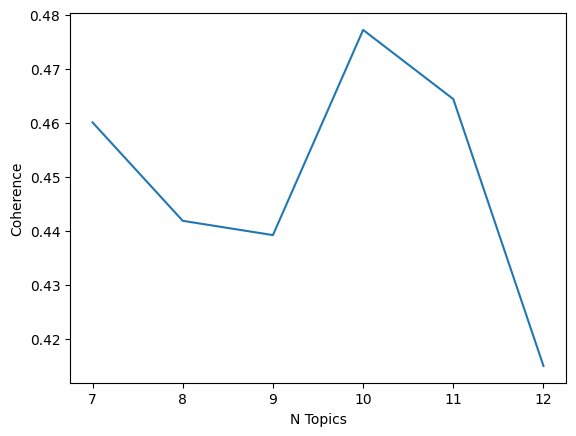

In [78]:
def plot_best_coherence(start, limit, step, coherence_values):
    """
    Visualization of Coherence Score.

    Parameters
    ----------
    limit: int
        Indicate the max. num of topics.
    start: int
        Indicate the min. num of topics.
    step: int
        The step size to increment the number of topics.
    coherence_values: list
        List of all scores of coherence model.
    """
    x = range(start, limit, step)
    plt.plot(x, coherence_values)
    plt.xlabel("N Topics")
    plt.ylabel("Coherence")
    plt.show()

plot_best_coherence(start=7, limit=13, step=1, coherence_values=coherence_values)

In [79]:
def get_best_model(model_list, coherence_list):
    """
    Selects the best LDA model based on the highest coherence score.

    Parameters
    ----------
    model_list: list of models (LDA)
        List of trained LDA models.
    coherence_list: list of float
        List of coherence scores corresponding to each model.

    Returns
    -------
    best_model: LDA Model
        The LDA model with the highest coherence score.
    best_coherence: float
        The highest coherence score.
    """
    idx_best = np.argmax(coherence_list)
    return model_list[idx_best], coherence_list[idx_best]

In [80]:
final_model, best_coherence_score = get_best_model(model_list, coherence_values)

# Show the most important words of each topic
topics = final_model.print_topics(num_words=10)
for topic in topics:
    print(topic)

print(f'Best Coherence Score: {best_coherence_score}')

(0, '0.018*"specie" + 0.014*"biological" + 0.014*"protein" + 0.012*"function" + 0.011*"biology" + 0.009*"population" + 0.009*"understand" + 0.008*"determine" + 0.008*"evolution" + 0.008*"genetic"')
(1, '0.044*"change" + 0.023*"climate" + 0.018*"global" + 0.017*"carbon" + 0.017*"environmental" + 0.016*"ecosystem" + 0.011*"marine" + 0.010*"coastal" + 0.010*"community" + 0.010*"natural"')
(2, '0.024*"technology" + 0.016*"propose" + 0.015*"manufacturing" + 0.014*"development" + 0.014*"potential" + 0.014*"process" + 0.010*"enable" + 0.009*"innovation" + 0.009*"reduce" + 0.009*"business"')
(3, '0.019*"social" + 0.013*"public" + 0.013*"health" + 0.012*"individual" + 0.011*"economic" + 0.010*"community" + 0.010*"information" + 0.010*"people" + 0.009*"understand" + 0.008*"examine"')
(4, '0.031*"material" + 0.023*"energy" + 0.017*"quantum" + 0.016*"property" + 0.012*"structure" + 0.010*"chemical" + 0.009*"fundamental" + 0.008*"chemistry" + 0.008*"surface" + 0.008*"experimental"')
(5, '0.016*"sur

#### e) Results

In [81]:
dominant_topics = []
for row_list in final_model[corpus]:
    row = row_list[0] if final_model.per_word_topics else row_list            
    row = sorted(row, key=lambda x: (x[1]), reverse=True)
    # Get dominant topic, contribution percentage and keywords.
    topic_num, prop_topic = row[0]
    # Append in dominant topics
    dominant_topics.append((topic_num, prop_topic))

# Create a DataFrame with topics
df_topics = pd.DataFrame(dominant_topics, columns=['dominant_topic', 'percentage_contribution'])

In [84]:
df_topics.head()

,dominant_topic,percentage_contribution
0,0,0.58
1,6,0.46
2,6,0.44
3,3,0.43
4,6,0.32


In [95]:
# Combine with Processed DataFrame
final_df = pd.concat([processed_df, df_topics], axis=1)
final_df.head()

,date,country,researcher,total_amount,text,clean text,dominant_topic,percentage_contribution
0,07/01/2020,United States,Janine M Ziermann-Canabarro,229338.00,Head and heart development are closely intertw...,"[development, closely, intertwine, embryonic, ...",0,0.58
1,01/01/2020,United States,Jay B Brockman,27438.00,The National Academy of Engineering identified...,"[national, academy, engineering, identify, com...",6,0.46
2,02/01/2020,United States,Tao Mei,49999.00,This award provides three years of funding to ...,"[provide, funding, defray, expense, participan...",6,0.44
3,09/01/2020,United States,Michael R O'Rourke,372421.00,"This collaborative research project, involving...","[collaborative, research, project, involve, mi...",3,0.43
4,05/01/2020,United States,Jacqueline A Smith,295500.00,Research Initiation Awards provide support for...,"[research, initiation, awards, provide, suppor...",6,0.32


- This visualization helps to better understand the topics generated by the model and how they relate to the documents in the corpus.

In [97]:
import pyLDAvis.gensim_models
import pyLDAvis

pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim_models.prepare(final_model, corpus, dictionary)
pyLDAvis.display(LDAvis_prepared)

### 4. Apply Criteria to Determinate Topics

In [98]:
# Dictionary to apply for each document
topic_ideal_name = {0: 'Materials Science and Quantum Energy',
                    1: 'Public Health and Social Behavior',
                    2: 'Computer Systems and Networks',
                    3: 'Science and University Development Programs',
                    4: 'Mathematical Theory and Methods',
                    5: 'Technological Development and Industrial Innovation',
                    6: 'Science and Technology Education',
                    7: 'Molecular and Evolutionary Biology',
                    8: 'Climate Change and Environmental Ecosystems',
                    9: 'Geosciences and Earth Observation'}

In [101]:
final_df['topic_name'] = final_df['dominant_topic'].map(topic_ideal_name)
final_df.head()

,date,country,researcher,total_amount,text,clean text,dominant_topic,percentage_contribution,topic_name
0,07/01/2020,United States,Janine M Ziermann-Canabarro,229338.00,Head and heart development are closely intertw...,"[development, closely, intertwine, embryonic, ...",0,0.58,Materials Science and Quantum Energy
1,01/01/2020,United States,Jay B Brockman,27438.00,The National Academy of Engineering identified...,"[national, academy, engineering, identify, com...",6,0.46,Science and Technology Education
2,02/01/2020,United States,Tao Mei,49999.00,This award provides three years of funding to ...,"[provide, funding, defray, expense, participan...",6,0.44,Science and Technology Education
3,09/01/2020,United States,Michael R O'Rourke,372421.00,"This collaborative research project, involving...","[collaborative, research, project, involve, mi...",3,0.43,Science and University Development Programs
4,05/01/2020,United States,Jacqueline A Smith,295500.00,Research Initiation Awards provide support for...,"[research, initiation, awards, provide, suppor...",6,0.32,Science and Technology Education


- It is necessary to know which is the topic with the most research projects.

In [103]:
final_df['topic_name'].value_counts()

topic_name
Mathematical Theory and Methods                        1797
Geosciences and Earth Observation                      1756
Science and University Development Programs            1488
Materials Science and Quantum Energy                   1408
Science and Technology Education                       1308
Computer Systems and Networks                          1247
Climate Change and Environmental Ecosystems            1159
Molecular and Evolutionary Biology                     1146
Technological Development and Industrial Innovation     965
Public Health and Social Behavior                       884
Name: count, dtype: int64

- It is necessary to know which project topic received the best funding award.

In [109]:
final_df.groupby(['researcher', 'topic_name']).agg({'total_amount':'sum'}).reset_index().sort_values(by='total_amount', ascending=False)

,researcher,topic_name,total_amount
3843,Francis L Halzen,Technological Development and Industrial Innov...,38380300.00
3242,Edward J Brook,Public Health and Social Behavior,25000000.00
11185,Tian Zheng,Public Health and Social Behavior,25000000.00
7405,Mark A Kasevich,Geosciences and Earth Observation,25000000.00
3224,Edo Waks,Mathematical Theory and Methods,25000000.00
...,...,...,...
11419,Vadim Roytershteyn,Science and Technology Education,2120.00
11030,Teresa A Murray,Science and Technology Education,2000.00
3370,Elizabeth L Crockett,Materials Science and Quantum Energy,1657.00
7966,Michael J Lee,Science and Technology Education,1355.00


## New Approach

In [118]:
from transformers import AutoTokenizer, AutoModel
import torch
from sklearn.cluster import KMeans

In [144]:
processed_df['joined_text'] = processed_df['clean text'].apply(lambda x: " ".join(x))

In [145]:
def load_pretrained_model():
    tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/distilbert-base-nli-stsb-mean-tokens")
    model = AutoModel.from_pretrained("sentence-transformers/distilbert-base-nli-stsb-mean-tokens")
    return tokenizer, model

In [146]:
def get_embeddings(texts, tokenizer, model):
    """
    This function helps to get embeddings.
    """
    encoded_input = tokenizer(texts, padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        model_output = model(**encoded_input)
    embeddings = model_output.last_hidden_state.mean(dim=1)
    return embeddings

In [147]:
tokenizer, model = load_pretrained_model()
embeddings = get_embeddings(processed_df['joined_text'].to_list(), tokenizer, model)